# MLPs For Univaraite Forecasting

In [64]:
#imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("data/Alcohol_Sales.csv", infer_datetime_format=True, index_col='DATE')

In [10]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [11]:
df.rename({"S4248SM144NCEN":"Sales"}, inplace=True, axis=1)

In [12]:
df.columns

Index(['Sales'], dtype='object')

In [13]:
df.columns

Index(['Sales'], dtype='object')

In [14]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [16]:
df.isna().sum()

Sales    0
dtype: int64

In [17]:
df.shape

(325, 1)

Hyperparameters:

- `n_input`: The number of lag observations to use as input to the model.
- `n_nodes`: The number of nodes to use in the hidden layer.
- `n_epochs`: The number of times to expose the model to the whole training dataset.
- `n_batch`: The number of samples within an epoch after which the weights are updated.

In [35]:
#hyperparameters
n_input = 12
n_nodes = 100
n_epochs = 100

In [42]:
325 - 16*19

21

In [31]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [39]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = pd.DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = pd.concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  
  return agg.values

series_to_supervised(df.values, 12)

array([[ 3459.,  3458.,  4002., ...,  4240.,  4936.,  3031.],
       [ 3458.,  4002.,  4564., ...,  4936.,  3031.,  3261.],
       [ 4002.,  4564.,  4221., ...,  3031.,  3261.,  4160.],
       ...,
       [13261., 14265.,  9564., ..., 12396., 13914., 14174.],
       [14265.,  9564., 10415., ..., 13914., 14174., 15504.],
       [ 9564., 10415., 12683., ..., 14174., 15504., 10718.]])

In [41]:
train, test = train_test_split(df, 21)

print(f"train shape : {train.shape}, test shape : {test.shape}")

train shape : (304, 1), test shape : (21, 1)


In [46]:
data = series_to_supervised(train, n_input)
train_x, train_y = data[:, :-1], data[:, -1]
train_x.shape, train_y.shape

((292, 12), (292,))

In [49]:
train_x.shape[0] * train_x.shape[1]

3504

In [50]:
train_x.shape

(292, 12)

In [129]:
# define model

class TimeSeriesMLPModel(nn.Module):

    def __init__(self, n_input, n_nodes) -> None:
        super().__init__()
        self.lm_linear = nn.Sequential(
            nn.Linear(in_features=n_input, out_features=n_nodes),
            nn.ReLU(),
            nn.Linear(in_features=n_nodes, out_features=1),
            )
    def forward(self, X):
        
        B, T = X.shape
        logits = self.lm_linear(X)
        return logits


In [130]:
n_input = 12
n_nodes = 100
mlp_model  = TimeSeriesMLPModel(n_input, n_nodes)

In [131]:
#loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters())


In [132]:
#convert datatype
train_x, train_y = torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)


/var/folders/xf/gcbfh98s6n53wh5f2hpb84nh0000gn/T/ipykernel_23539/4274117446.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x, train_y = torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)


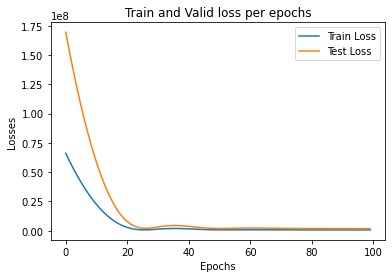

In [133]:
#training loop

train_losses = []
test_losses = []

for _ in range(n_epochs):
    
    optimizer.zero_grad()
    logits = mlp_model.forward(train_x)
    loss = criterion(logits.view(-1), train_y)
    train_losses.append(loss.item())
    #validation
    #history
    with torch.no_grad():
        history = train_x[-1].tolist() + train_y[-1][None].tolist()

        y_pred_values = []
        y_true = []
        for i in range(len(test)):

            test_points = torch.tensor(history[-n_input:], dtype=torch.float32).view(1, n_input)
            yhat =  mlp_model.forward(test_points)
            history.append(test[i][0])
            y_pred_values.append(yhat.item())
            y_true.append(test[i][0])

        y_pred_values = torch.tensor(y_pred_values, dtype=torch.float32)
        y_true = torch.tensor(y_true, dtype=torch.float32)
        test_loss = criterion(y_pred_values, y_true)
        test_losses.append(test_loss.item())
    loss.backward()
    optimizer.step()

# Plot the first graph
plt.plot(train_losses, label='Train Loss')

# Plot the second graph on the same plot
plt.plot(test_losses, label='Test Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train and Valid loss per epochs')
plt.legend()

# Show the plot
plt.show()


## Model Evaluation

In [120]:
train_x[0], train_y[0]

(tensor([3459., 3458., 4002., 4564., 4221., 4529., 4466., 4137., 4126., 4259.,
         4240., 4936.]),
 tensor(3031.))

In [73]:
train_x[1], train_y[1]

(tensor([3458., 4002., 4564., 4221., 4529., 4466., 4137., 4126., 4259., 4240.,
         4936., 3031.]),
 tensor(3261.))

In [82]:
test = test.values

In [86]:
train_y[-1].to

11491.0

In [91]:
train_y[-1][None].tolist()

[11491.0]

In [95]:
#history
history = train_x[-1].tolist() + train_y[-1][None].tolist()
len(history)
torch.tensor(history[-n_input:], dtype=torch.float32).shape

torch.Size([12])

In [100]:
test[0]

array([13545])

In [103]:
#history
history = train_x[-1].tolist() + train_y[-1][None].tolist()

y_pred_values = []
y_true = []
for i in range(len(test)):

    test_points = torch.tensor(history[-n_input:], dtype=torch.float32).view(1, n_input)
    yhat =  mlp_model.forward(test_points)
    history.append(test[i][0])
    y_pred_values.append(yhat.item())
    y_true.append(test[i][0])

y_pred_values = torch.tensor(y_pred_values, dtype=torch.float32)
y_true = torch.tensor(y_true, dtype=torch.float32)
test_loss = criterion(y_pred_values, y_true)

print(f"Test loss : {test_loss}")


Test loss : 2197143.25
